In [1]:
import matplotlib.pyplot as plt
import math
import torch

import sampling_algs # all relevant methods can be found here
import utils # only to import the pointcloud

In [2]:
n_points = int(math.pow(2,13))
train_dataset = utils.import_train(n_points, path=None) # path = relative path to modelnet10 folder
n_points

8192

In [3]:
pos_all = train_dataset.pos

In [4]:
k = 10
ratio = .5
bias = 0.99
batch_size = 32

In [5]:
batch = torch.mul(torch.arange(0,batch_size), torch.ones((n_points, batch_size))).T.reshape(-1).long()

In [6]:
torch.set_printoptions(profile="full")

In [8]:
batch[:8192]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
pos_batch1 = pos_all[:batch_size*n_points] # extract the first batch of clouds

Text(0.5, 0, 'Z')

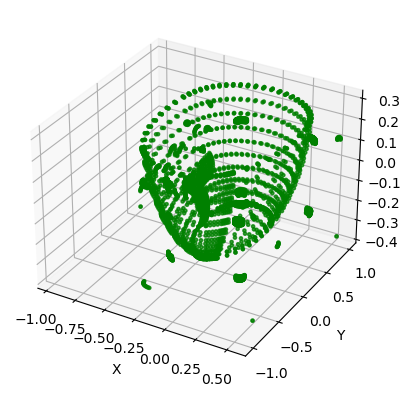

In [37]:
test = pos_batch1[:8192,:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter3 = ax.scatter(test[:,0], test[:,1], test[:,2], marker='.',alpha=.5,color="green")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [33]:
def batch_sampling_coordinator(x, batch, ratio, sampler, k):
    """
    Coordinate batch-wise point cloud sampling.

    :param x: Tensor of shape (N, C) representing the point cloud data.
    :param batch: Tensor of shape (N,) representing the batch indices of the points.
    :param ratio: Sampling ratio for each point cloud in the batch.
    :param sampler: Sampling algorithm function to be used for sampling points in each point cloud.
    :param sampler_args: Additional arguments to be passed to the sampler function.
    :return: Tensor of shape (M,) containing the indices of the sampled points across the entire batch.

    If `batch` is not None, it should be a tensor of batch indices for each point in `x`. The batch indices
    help identify the point clouds in the batch. It is assumed that `x` and `batch` have compatible shapes,
    with `x` having the same number of points as the length of `batch`.

    The function operates on a batch of point clouds and coordinates the sampling process. It first checks if
    `batch` is provided and performs necessary checks on the sizes and dimensions. It then reshapes `x` into
    individual point clouds. For each point cloud, it calls the provided `sampler` function to sample the
    desired number of points based on the specified `ratio`. The sampled point indices are adjusted to account
    for the position of each point cloud in the batch, and the indices are stored in the output tensor `out`.

    Note: The `sampler` function should take in a point cloud tensor, the desired nr of points, and any additional arguments
    specified in `sampler_args`. It should return the indices of the sampled points within the given point
    cloud.
    """
    if batch is not None:
        assert x.size(0) == batch.numel()
        batch_size = int(batch.max()) + 1

        deg = x.new_zeros(batch_size, dtype=torch.long)
        deg.scatter_add_(0, batch, torch.ones_like(batch))

        ptr = deg.new_zeros(batch_size + 1)
        torch.cumsum(deg, 0, out=ptr[1:])
    else:
        batch = torch.tensor([0, x.size(0)], device=x.device)

    unique_batch = torch.unique(batch)
    num_point_clouds = unique_batch[-1] + 1  # e.g., 32
    nr_points_per_cloud = int(x.size(0) / num_point_clouds)
    x_reshaped = x.view(num_point_clouds, nr_points_per_cloud, -1)  # [32, 40, 3])

    test = x[:nr_points_per_cloud,:]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter3 = ax.scatter(test[:,0], test[:,1], test[:,2], marker='.',alpha=.5,color="green")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # rotate_plot()
    ax.view_init(elev=30, azim=340)
    plt.show(block=True)
    raise KeyboardInterrupt
    # Iterate over the point clouds
    desired_num_points = math.ceil(ratio * nr_points_per_cloud)
    out = torch.empty(desired_num_points * num_point_clouds, dtype=torch.long)
    for i in range(num_point_clouds):
        cloud = x_reshaped[i, :, :]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scatter3 = ax.scatter(cloud[:,0], cloud[:,1], cloud[:,2], marker='.',alpha=.5,color="green")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        # rotate_plot()
        ax.view_init(elev=30, azim=340)
        plt.show(block=True)
        if i == 2:
            raise KeyboardInterrupt


        # compute
        # curve_idx_reordered = sampling_algs.max_curve_sampler(cloud, desired_num_points, k)
        # ptr = i * nr_points_per_cloud  # shift local point index by cloud index
        # out[i * desired_num_points:i*desired_num_points + curve_idx_reordered.size(0)] = curve_idx_reordered + ptr

    return out


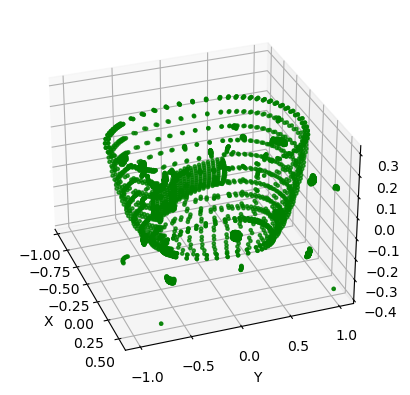

KeyboardInterrupt: 

In [34]:
# sampler_args = [k]
# sampler = sampling_algs.max_curve_sampler


# sampler_args = [bias, sampling_algs.max_curve_sampler, k]
# sampler = sampling_algs.bias_anyvsfps_sampler
k = 10
ratio = .5

idx =  batch_sampling_coordinator(pos_batch1, batch, ratio, None, k) # this method is broken, clouds looks incorrect
idx

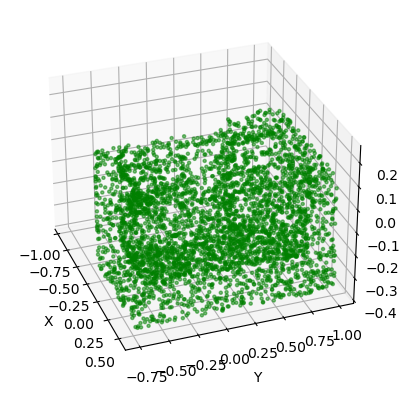

tensor([[-2.3663e-01,  7.7140e-01,  4.3395e-02],
        [ 5.2693e-01,  7.5495e-01, -3.7004e-01],
        [ 5.3758e-01,  3.5083e-02, -2.6756e-01],
        [ 2.6710e-01, -5.9551e-01, -2.3470e-01],
        [ 3.9218e-01, -2.3354e-01,  1.2680e-01],
        [-2.1851e-02, -7.4633e-01, -3.5091e-02],
        [ 1.7203e-01,  9.1704e-02, -2.4912e-01],
        [ 3.8827e-01, -3.4825e-01, -2.2788e-01],
        [-2.3651e-02, -3.7762e-01,  8.0656e-02],
        [-6.5035e-01,  8.1501e-01, -7.2901e-03],
        [-2.2909e-01, -4.8694e-01, -2.4481e-01],
        [ 5.3758e-01,  5.7160e-01, -1.7680e-01],
        [ 5.1279e-02, -1.2797e-01, -2.4912e-01],
        [ 1.9292e-01, -5.9720e-01,  1.5460e-02],
        [ 2.1411e-02,  8.5020e-01,  7.0830e-02],
        [ 2.0495e-01,  9.9934e-01, -1.7007e-01],
        [-3.8577e-01,  3.1960e-01,  6.6173e-02],
        [-2.2875e-01,  4.8021e-01, -3.7004e-01],
        [-5.5090e-01,  5.2036e-01, -2.9995e-01],
        [-3.8577e-01, -9.5165e-02, -3.6897e-01],
        [-3.8577e-01

In [17]:
cloud = train_dataset[1].pos

res = cloud[idx[:int(ratio*n_points)],:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter3 = ax.scatter(res[:,0], res[:,1], res[:,2], marker='.',alpha=.5,color="green")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate_plot()
ax.view_init(elev=30, azim=340)
plt.show(block=True)
res

In [11]:
%matplotlib qt
h = 1
cloud = train_dataset[h].pos
des_n_points = int(n_points*ratio)
index_range = idx[h* des_n_points: (h)* des_n_points + des_n_points] - int(h*n_points)

print(index_range)
x = cloud[index_range, 0]
y = cloud[index_range, 1]
z = cloud[index_range, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter3 = ax.scatter(x, y, z, marker='.',alpha=.5,color="green")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate_plot()
ax.view_init(elev=30, azim=340)
plt.show(block=True)

tensor([4972, 4971, 4993,  ..., 1311, 1219,  897])


---

#### Max curve sampler in isolation

- the max curve sampler gives the correct pointcloud

In [12]:
ratio = 0.2
cloud = train_dataset[h].pos
des_nr_points = int(ratio*n_points)
test_idxs = sampling_algs.max_curve_sampler(cloud,des_nr_points,k)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter3 = ax.scatter(cloud[test_idxs,0], cloud[test_idxs,1], cloud[test_idxs,2], marker='.',alpha=.5,color="green")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate_plot()
ax.view_init(elev=30, azim=340)
plt.show(block=True)

#### Bias sampler in isolation

- here too the expected pointcloud

In [21]:
h = 1
cloud = train_dataset[h].pos
ratio = .5
bias = .99

des_nr_points = int(ratio*n_points)
test_idxs = sampling_algs.bias_anyvsfps_sampler(cloud,des_nr_points,bias, func1=sampling_algs.max_curve_sampler, args1=k)

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter3 = ax.scatter(cloud[test_idxs,0], cloud[test_idxs,1], cloud[test_idxs,2], marker='.',alpha=.5,color="green")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate_plot()
ax.view_init(elev=30, azim=340)
plt.show(block=True)